# <center> Text Vectorization and Word Embedding

**Case Description**

Marketplace's clients want to get possibility to check the same product position from different sellers. Our instrument sholud help them to get product cards by product id in online stores based on their descriptions.

**Task**
* Getting Vector representations of text data
* Using these represenations to get recommendation of similar product.

**Data**: sample_data file contains 500 unique ids. Columns:
- *id number*,
- field with *text description* - product name and product description

**ML task**: NLP (getting word embeddings) + Recommendation based on cosine similarity value

**Metrics**: cosine similarity

*Training on CPU*

# 0. Install and Import

In [1]:
import numpy as np #linear algebra
import pandas as pd #data processing, CSV file I/O (e.g. pd.read_csv)
import re #regular expression

# Libs for visualization
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter, defaultdict

# For Word2Vec models
import gensim
import gensim.downloader as api
from gensim.models import Word2Vec

# Text preprocessing
import nltk
import subprocess

# Download and unzip wordnet
try:
    nltk.data.find("wordnet.zip")
except:
    nltk.download("wordnet", download_dir="/kaggle/working/")
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append("/kaggle/working/")
    
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords #list of lexical stop words
from nltk import word_tokenize, pos_tag, pos_tag_sents
nltk.download("stopwords")
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  # Metric for measuring the similarity between two vectors
# Metrics
from scipy.stats import normaltest # D'Agostino's K-squared test
# from string import punctuation #sets of punctuation

[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/corpora/wordnet/README  
  inflating: /kaggle/working/corpora/wordnet/index.sense  
  inflating: /kaggle/working/corpora/wordnet/data.

In [2]:
# Fixing RANDOM_SEED to make experiment repetable
RANDOM_SEED = 42

# Fixing package versions to make experiment repetable
!pip freeze > requirements.txt

# 1. Data Loading: dataset exploration

In [3]:
# Reading dataset's file
DATA_DIR = "/kaggle/input/product-item-data"
sample_data = pd.read_csv(DATA_DIR+"/sample-data.csv")

print("Data:\n")
display(sample_data.head())

print(f"Dataset`s shape: {sample_data.shape}")

Data:



,id,description
0,1,Active classic boxers - There's a reason why o...
1,2,Active sport boxer briefs - Skinning up Glory ...
2,3,Active sport briefs - These superbreathable no...
3,4,"Alpine guide pants - Skin in, climb ice, switc..."
4,5,"Alpine wind jkt - On high ridges, steep ice an..."


Dataset`s shape: (500, 2)


In [4]:
print(f'Number of unique product_id: {sample_data.id.nunique()}')

Number of unique product_id: 500


Some observations:
* Full dataset contains information about 500 unique product ids.
* The most interesting column is *description*. It presents product name and product description. It will be our features in this project.

Maybe it has no sense, but anyway I want to get product name and description separately.

In [5]:
# Make a copy of dataset
data = sample_data.copy()

In [6]:
# rename Description column -> Full_description
data = data.rename(columns = {"description": "full_description"})

# get product name and description as elements of list separated by special symbol (" - ")
# symbol with space!!! because there are complex words with this symbol (t-shirt)
data["temp_description"] = data["full_description"].apply(lambda x: re.split(" - ", x))
data.head()

,id,full_description,temp_description
0,1,Active classic boxers - There's a reason why o...,"[Active classic boxers, There's a reason why o..."
1,2,Active sport boxer briefs - Skinning up Glory ...,"[Active sport boxer briefs, Skinning up Glory ..."
2,3,Active sport briefs - These superbreathable no...,"[Active sport briefs, These superbreathable no..."
3,4,"Alpine guide pants - Skin in, climb ice, switc...","[Alpine guide pants, Skin in, climb ice, switc..."
4,5,"Alpine wind jkt - On high ridges, steep ice an...","[Alpine wind jkt, On high ridges, steep ice an..."


In [7]:
# product name is the first element
data["product_name"] = data["temp_description"].apply(lambda x: x[0])

# product description includes other elements in a list
data["product_desc"] = data["temp_description"].apply(lambda x: x[1:])
data["product_desc"] = data["product_desc"].apply(lambda x: ' '.join(x))

data.drop("temp_description", inplace=True, axis=1)

In [8]:
data.head(10)

,id,full_description,product_name,product_desc
0,1,Active classic boxers - There's a reason why o...,Active classic boxers,There's a reason why our boxers are a cult fav...
1,2,Active sport boxer briefs - Skinning up Glory ...,Active sport boxer briefs,Skinning up Glory requires enough movement wit...
2,3,Active sport briefs - These superbreathable no...,Active sport briefs,These superbreathable no-fly briefs are the mi...
3,4,"Alpine guide pants - Skin in, climb ice, switc...",Alpine guide pants,"Skin in, climb ice, switch to rock, traverse a..."
4,5,"Alpine wind jkt - On high ridges, steep ice an...",Alpine wind jkt,"On high ridges, steep ice and anything alpine,..."
5,6,Ascensionist jkt - Our most technical soft she...,Ascensionist jkt,Our most technical soft shell for full-on moun...
6,7,"Atom - A multitasker's cloud nine, the Atom pl...",Atom,"A multitasker's cloud nine, the Atom plays the..."
7,8,Print banded betina btm - Our fullest coverage...,Print banded betina btm,"Our fullest coverage bottoms, the Betina fits ..."
8,9,Baby micro d-luxe cardigan - Micro D-Luxe is a...,Baby micro d-luxe cardigan,Micro D-Luxe is a heavenly soft fabric with do...
9,10,Baby sun bucket hat - This hat goes on when th...,Baby sun bucket hat,This hat goes on when the sun rises above the ...


In [9]:
# Checking for duplicate product_name
data.groupby(["product_name"])["product_desc"].nunique().reset_index().sort_values(by='product_desc', ascending=False)[:10]

,product_name,product_desc
407,Watermaster waders,4
299,Riverwalker,3
89,Compound cargo pants,3
374,Torrentshell jkt,3
375,Torrentshell pants,3
110,Duck pants,3
82,Cap 3 crew,3
98,Custodian pants,3
42,Baggies shorts,3
195,Live simply guitar t-shirt,3


* Product name could be the same, but *id number* and *description* are different

# 2. Text Preprocessing

Text preprocessing is the practice of cleaning and preparing text data. This is one of the most crucial steps in the process.

Using NLTK, text information are then pre-processed with the following:

* tokenization — convert sentences to words
* converting the text to lower case
* stopwords removal - frequent words which have not any semantic sense
* removing punctuation, numerical values, some extra examples
* lemmatization - convert the word into a root word
* part-of-speech tagging - removing noninformative POS
* vectorization - numerically representation of text (tf-idf vectorization)

At every stage is necessary go through the text manually to try "catch" examples which can definitely show up and hurt the model.

In [10]:
# Let's make a copy of the given DataFrame in order to protect original DF
df_temp = data.copy()

In [11]:
df_temp["full_description"][0]

'Active classic boxers - There\'s a reason why our boxers are a cult favorite - they keep their cool, especially in sticky situations. The quick-drying, lightweight underwear takes up minimal space in a travel pack. An exposed, brushed waistband offers next-to-skin softness, five-panel construction with a traditional boxer back for a classic fit, and a functional fly. Made of 3.7-oz 100% recycled polyester with moisture-wicking performance. Inseam (size M) is 4 1/2". Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>"Silky Capilene 1 fabric is ultralight, breathable and quick-to-dry"</li> <li>"Exposed, brushed elastic waistband for comfort"</li> <li>5-panel construction with traditional boxer back</li> <li>"Inseam (size M) is 4 1/2"""</li></ul><br><br><b>Fabric: </b>3.7-oz 100% all-recycled polyester with Gladiodor natural odor control for the garment. Recyclable through the Common Threads Recycling Program<br><br><b>Weight: </b>99 g (3.5 oz)<br><b

Some observations:
* Description text has uppercase and lowercase letters
* There are Font formatting tags: ul, br, et.s.
* Size number (4 1/2), Weight (g, oz), Composition of clothing (100% all-recycled polyester)

During Text preprocessing we need to solve these points.


## 2.1 Text preprocessing: Part-of-Speech tagging (POS)

Previously I want to do part-of-speech tagging. This step is important for lemmatisation to work, as words which have different meanings depending on part of speech. So, it would be better if POS Tagging implementation is done first.

Also we need to remove not informative words, as prononuns, which is not define product.

`What is Part of Speech Tagging?`

Part of Speech Tagging is the process of associating each word in a piece of text with a particular tag, which represents the type of word it is, i.e. proper noun, comparative adjective, interjection etc.

The Universal tagset shown below is a simplified POS tagset:
* CC coordinating conjunction
* CD cardinal digit
* DT determiner
* EX existential there (like: “there is” … think of it like “there exists”)
* FW foreign word
* IN preposition/subordinating conjunction
* JJ adjective ‘big’
* JJR adjective, comparative ‘bigger’
* JJS adjective, superlative ‘biggest’
* LS list marker 1)
* MD modal could, will
* NN noun, singular ‘desk’
* NNS noun plural ‘desks’
* NNP proper noun, singular ‘Harrison’
* NNPS proper noun, plural ‘Americans’
* PDT predeterminer ‘all the kids’
* POS possessive ending parent’s
* PRP personal pronoun I, he, she
* PRP\$ possessive pronoun my, his, hers
* RB adverb very, silently,
* RBR adverb, comparative better
* RBS adverb, superlative best
* RP particle give up
* TO, to go "to" the store
* UH interjection, errrrrrrrm
* VB verb, base form take
* VBD verb, past tense, took
* VBG verb, gerund/present participle taking
* VBN verb, past participle taken
* VBP verb, sing. present, non-3d take
* VBZ verb, 3rd person sing. present takes
* WDT wh-determiner which
* WP wh-pronoun who, what
* WP$ possessive wh-pronoun whose
* WRB wh-adverb where, when

In [12]:
def text_preprocessing(data):
    """
    - Splitting the text into separate words (token) by capital letter
    (! Be careful with regex in order to save correct version of words writting by capslock)
    - Converting all the characeters to lower case
    """
    data["full_desc_token"] = data["full_description"].apply(lambda x: re.sub( r"([A-Z][^a-z]*)", r" \1", x))
    data["full_desc_lower"] = data["full_desc_token"].str.lower()
    
    return data

In [13]:
"""
Part-of-speech tagging
"""

def get_pos(data):
    """
    Get column: list of pair - (token, part-of-speech)
    """
    texts = data["full_desc_lower"].tolist() #extract the Text column to a list of string
    tagged_texts = pos_tag_sents(map(word_tokenize, texts))
    
    #add the column back to the DataFrame
    data["POS"] = tagged_texts

    return data


def get_informative_token(data):
    """
    Get list of pair with POS which one play a role in define product
    Delete noninformative part-of-speech: pronouns, preposition and postposition, etc.
    """
    pos_noninformative = ["CD", "DT", "IN", "LS", "MD", "POS", "PRP",
                          "PRP$", "TO", "UH", "WDT", "WP", "WP$", "WRB", "EX"]
    special_tags = ["br", "li", "ul", "b", "/br", "/li", "/ul", "/b"] #html_el
    
    data["POS_clean"] = data["POS"].apply(lambda x: [pair for pair in x if pair[0] not in special_tags and pair[1] not in pos_noninformative])
    
    return data


def get_only_token(data):
    """
    Get column: list of token with meaningful part-of-speech
    """
    data["clean_token"] = data["POS_clean"].apply(lambda x: [word[0] for word in x])
    
    return data


def get_count_of_tokens(data):
    """
    Get column with words number in product description
    """
    data["token_number"] = data["clean_token"].apply(lambda x: len(x))
    
    return data

In [14]:
"""
Text preprocessing:
- get tokens (separate words)
- convert tokens to lower case
"""
df_temp = text_preprocessing(df_temp)

In [15]:
"""
Get POS tags
"""
df_temp = get_pos(df_temp)
df_temp = get_informative_token(df_temp)
df_temp = get_only_token(df_temp)
df_temp = get_count_of_tokens(df_temp)

df_temp.head(2)

,id,full_description,product_name,product_desc,full_desc_token,full_desc_lower,POS,POS_clean,clean_token,token_number
0,1,Active classic boxers - There's a reason why o...,Active classic boxers,There's a reason why our boxers are a cult fav...,Active classic boxers - There's a reason why...,active classic boxers - there's a reason why...,"[(active, JJ), (classic, JJ), (boxers, NNS), (...","[(active, JJ), (classic, JJ), (boxers, NNS), (...","[active, classic, boxers, -, 's, reason, boxer...",180
1,2,Active sport boxer briefs - Skinning up Glory ...,Active sport boxer briefs,Skinning up Glory requires enough movement wit...,Active sport boxer briefs - Skinning up Glo...,active sport boxer briefs - skinning up glo...,"[(active, JJ), (sport, NN), (boxer, NN), (brie...","[(active, JJ), (sport, NN), (boxer, NN), (brie...","[active, sport, boxer, briefs, -, skinning, up...",206


In [16]:
# Look at the examlpe
# df_temp['POS_clean'][0]

In [17]:
# [[subelt for subelt in elt if len(subelt) > 1 and "'" in subelt] for elt in df_temp["clean_token"]][0]

In [18]:
"""
Delete tokens with 1 character (different symbols)

1 character sometimes contains information about size (S, M, L).
But I'm not sure that in this task it has a sense.

Also I want to check tokens with 2-3 characters consist of "'s", "n't" and delete them.
"""
df_temp["clean_token"] = [[subelt for subelt in elt if len(subelt) > 1 and "'" not in subelt] for elt in df_temp["clean_token"]]

# update count_token_number
df_temp = get_count_of_tokens(df_temp)
df_temp.head()

,id,full_description,product_name,product_desc,full_desc_token,full_desc_lower,POS,POS_clean,clean_token,token_number
0,1,Active classic boxers - There's a reason why o...,Active classic boxers,There's a reason why our boxers are a cult fav...,Active classic boxers - There's a reason why...,active classic boxers - there's a reason why...,"[(active, JJ), (classic, JJ), (boxers, NNS), (...","[(active, JJ), (classic, JJ), (boxers, NNS), (...","[active, classic, boxers, reason, boxers, are,...",92
1,2,Active sport boxer briefs - Skinning up Glory ...,Active sport boxer briefs,Skinning up Glory requires enough movement wit...,Active sport boxer briefs - Skinning up Glo...,active sport boxer briefs - skinning up glo...,"[(active, JJ), (sport, NN), (boxer, NN), (brie...","[(active, JJ), (sport, NN), (boxer, NN), (brie...","[active, sport, boxer, briefs, skinning, up, g...",104
2,3,Active sport briefs - These superbreathable no...,Active sport briefs,These superbreathable no-fly briefs are the mi...,Active sport briefs - These superbreathable ...,active sport briefs - these superbreathable ...,"[(active, JJ), (sport, NN), (briefs, SYM), (-,...","[(active, JJ), (sport, NN), (briefs, SYM), (-,...","[active, sport, briefs, superbreathable, no-fl...",87
3,4,"Alpine guide pants - Skin in, climb ice, switc...",Alpine guide pants,"Skin in, climb ice, switch to rock, traverse a...","Alpine guide pants - Skin in, climb ice, swi...","alpine guide pants - skin in, climb ice, swi...","[(alpine, NN), (guide, NN), (pants, NNS), (-, ...","[(alpine, NN), (guide, NN), (pants, NNS), (-, ...","[alpine, guide, pants, skin, climb, ice, switc...",134
4,5,"Alpine wind jkt - On high ridges, steep ice an...",Alpine wind jkt,"On high ridges, steep ice and anything alpine,...","Alpine wind jkt - On high ridges, steep ice ...","alpine wind jkt - on high ridges, steep ice ...","[(alpine, NN), (wind, NN), (jkt, NN), (-, :), ...","[(alpine, NN), (wind, NN), (jkt, NN), (-, :), ...","[alpine, wind, jkt, high, ridges, steep, ice, ...",202


In [19]:
# Put back tokens into one single string for lemmatization
df_temp["clean_full_desc"] = [" ".join(x) for x in df_temp["clean_token"]]

df_temp.head(5)

,id,full_description,product_name,product_desc,full_desc_token,full_desc_lower,POS,POS_clean,clean_token,token_number,clean_full_desc
0,1,Active classic boxers - There's a reason why o...,Active classic boxers,There's a reason why our boxers are a cult fav...,Active classic boxers - There's a reason why...,active classic boxers - there's a reason why...,"[(active, JJ), (classic, JJ), (boxers, NNS), (...","[(active, JJ), (classic, JJ), (boxers, NNS), (...","[active, classic, boxers, reason, boxers, are,...",92,active classic boxers reason boxers are cult f...
1,2,Active sport boxer briefs - Skinning up Glory ...,Active sport boxer briefs,Skinning up Glory requires enough movement wit...,Active sport boxer briefs - Skinning up Glo...,active sport boxer briefs - skinning up glo...,"[(active, JJ), (sport, NN), (boxer, NN), (brie...","[(active, JJ), (sport, NN), (boxer, NN), (brie...","[active, sport, boxer, briefs, skinning, up, g...",104,active sport boxer briefs skinning up glory re...
2,3,Active sport briefs - These superbreathable no...,Active sport briefs,These superbreathable no-fly briefs are the mi...,Active sport briefs - These superbreathable ...,active sport briefs - these superbreathable ...,"[(active, JJ), (sport, NN), (briefs, SYM), (-,...","[(active, JJ), (sport, NN), (briefs, SYM), (-,...","[active, sport, briefs, superbreathable, no-fl...",87,active sport briefs superbreathable no-fly bri...
3,4,"Alpine guide pants - Skin in, climb ice, switc...",Alpine guide pants,"Skin in, climb ice, switch to rock, traverse a...","Alpine guide pants - Skin in, climb ice, swi...","alpine guide pants - skin in, climb ice, swi...","[(alpine, NN), (guide, NN), (pants, NNS), (-, ...","[(alpine, NN), (guide, NN), (pants, NNS), (-, ...","[alpine, guide, pants, skin, climb, ice, switc...",134,alpine guide pants skin climb ice switch rock ...
4,5,"Alpine wind jkt - On high ridges, steep ice an...",Alpine wind jkt,"On high ridges, steep ice and anything alpine,...","Alpine wind jkt - On high ridges, steep ice ...","alpine wind jkt - on high ridges, steep ice ...","[(alpine, NN), (wind, NN), (jkt, NN), (-, :), ...","[(alpine, NN), (wind, NN), (jkt, NN), (-, :), ...","[alpine, wind, jkt, high, ridges, steep, ice, ...",202,alpine wind jkt high ridges steep ice and anyt...


## 2.2 Text preprocessing: Lemmatization

In [20]:
"""
After getting POS and deleting some of them we can use lemmatization
which will return the base form or lemma
"""
wnl = WordNetLemmatizer()
patterns = "[^a-zA-Z \n\.]"

# Use stopwords list from nltk
stopwords_eng = stopwords.words("english")

# Look at the base stopwords list
print(f"Base stopwords list:{stopwords_eng}")

# add extra stopwords
stopwords_eng.extend(["oz", "g", "common"])


def lemmatize_sentence(text):
    text = re.sub(patterns, " ", text)
    tokens = []
    
    for token in text.split():
        if token and token not in stopwords_eng:
            token = token.strip()
            token = wnl.lemmatize(token)
            
            if len(token) == 1: continue #delete "." after removing numerical symbol (4.6 oz)
            else:
                tokens.append(token)
            
    return " ".join(tokens) # back to string from list

Base stopwords list:['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'sa

In [21]:
print("Full text description before cleaning:\n", df_temp["clean_full_desc"].iloc[0])
print("\nBefore lemmatization:\n", df_temp["clean_full_desc"].iloc[0])
print("\nAfter lemmatization:\n", lemmatize_sentence(df_temp["clean_full_desc"].iloc[0]))

Full text description before cleaning:
 active classic boxers reason boxers are cult favorite keep cool especially sticky situations quick-drying lightweight underwear takes up minimal space travel pack exposed brushed waistband offers next-to-skin softness five-panel construction traditional boxer back classic fit and functional fly made 3.7-oz recycled polyester moisture-wicking performance inseam size is recyclable common threads recycling program. details silky capilene fabric is ultralight breathable and quick-to-dry exposed brushed elastic waistband comfort 5-panel construction traditional boxer back inseam size is fabric 3.7-oz all-recycled polyester gladiodor natural odor control garment recyclable common threads recycling program weight oz made mexico

Before lemmatization:
 active classic boxers reason boxers are cult favorite keep cool especially sticky situations quick-drying lightweight underwear takes up minimal space travel pack exposed brushed waistband offers next-to-s

In [22]:
# Get new column with lemmatize text
df_temp["full_desc_lem"] = df_temp["clean_full_desc"].apply(lemmatize_sentence)
df_temp.head(2)

,id,full_description,product_name,product_desc,full_desc_token,full_desc_lower,POS,POS_clean,clean_token,token_number,clean_full_desc,full_desc_lem
0,1,Active classic boxers - There's a reason why o...,Active classic boxers,There's a reason why our boxers are a cult fav...,Active classic boxers - There's a reason why...,active classic boxers - there's a reason why...,"[(active, JJ), (classic, JJ), (boxers, NNS), (...","[(active, JJ), (classic, JJ), (boxers, NNS), (...","[active, classic, boxers, reason, boxers, are,...",92,active classic boxers reason boxers are cult f...,active classic boxer reason boxer cult favorit...
1,2,Active sport boxer briefs - Skinning up Glory ...,Active sport boxer briefs,Skinning up Glory requires enough movement wit...,Active sport boxer briefs - Skinning up Glo...,active sport boxer briefs - skinning up glo...,"[(active, JJ), (sport, NN), (boxer, NN), (brie...","[(active, JJ), (sport, NN), (boxer, NN), (brie...","[active, sport, boxer, briefs, skinning, up, g...",104,active sport boxer briefs skinning up glory re...,active sport boxer brief skinning glory requir...


In [23]:
# Update token_number_after_lem column
df_temp["token_number_after_lem"] = [len(word.split()) for word in df_temp["full_desc_lem"]]
df_temp.head()

,id,full_description,product_name,product_desc,full_desc_token,full_desc_lower,POS,POS_clean,clean_token,token_number,clean_full_desc,full_desc_lem,token_number_after_lem
0,1,Active classic boxers - There's a reason why o...,Active classic boxers,There's a reason why our boxers are a cult fav...,Active classic boxers - There's a reason why...,active classic boxers - there's a reason why...,"[(active, JJ), (classic, JJ), (boxers, NNS), (...","[(active, JJ), (classic, JJ), (boxers, NNS), (...","[active, classic, boxers, reason, boxers, are,...",92,active classic boxers reason boxers are cult f...,active classic boxer reason boxer cult favorit...,85
1,2,Active sport boxer briefs - Skinning up Glory ...,Active sport boxer briefs,Skinning up Glory requires enough movement wit...,Active sport boxer briefs - Skinning up Glo...,active sport boxer briefs - skinning up glo...,"[(active, JJ), (sport, NN), (boxer, NN), (brie...","[(active, JJ), (sport, NN), (boxer, NN), (brie...","[active, sport, boxer, briefs, skinning, up, g...",104,active sport boxer briefs skinning up glory re...,active sport boxer brief skinning glory requir...,100
2,3,Active sport briefs - These superbreathable no...,Active sport briefs,These superbreathable no-fly briefs are the mi...,Active sport briefs - These superbreathable ...,active sport briefs - these superbreathable ...,"[(active, JJ), (sport, NN), (briefs, SYM), (-,...","[(active, JJ), (sport, NN), (briefs, SYM), (-,...","[active, sport, briefs, superbreathable, no-fl...",87,active sport briefs superbreathable no-fly bri...,active sport brief superbreathable fly brief m...,84
3,4,"Alpine guide pants - Skin in, climb ice, switc...",Alpine guide pants,"Skin in, climb ice, switch to rock, traverse a...","Alpine guide pants - Skin in, climb ice, swi...","alpine guide pants - skin in, climb ice, swi...","[(alpine, NN), (guide, NN), (pants, NNS), (-, ...","[(alpine, NN), (guide, NN), (pants, NNS), (-, ...","[alpine, guide, pants, skin, climb, ice, switc...",134,alpine guide pants skin climb ice switch rock ...,alpine guide pant skin climb ice switch rock t...,128
4,5,"Alpine wind jkt - On high ridges, steep ice an...",Alpine wind jkt,"On high ridges, steep ice and anything alpine,...","Alpine wind jkt - On high ridges, steep ice ...","alpine wind jkt - on high ridges, steep ice ...","[(alpine, NN), (wind, NN), (jkt, NN), (-, :), ...","[(alpine, NN), (wind, NN), (jkt, NN), (-, :), ...","[alpine, wind, jkt, high, ridges, steep, ice, ...",202,alpine wind jkt high ridges steep ice and anyt...,alpine wind jkt high ridge steep ice anything ...,189


***

## Descriptive statistics for word count

In text analysis, descriptive statistics play a crucial role in summarizing and understanding the characteristics of textual data.
- min/ max/ mean number of words in product description,
- the most popular and rare words,
- popular part of speech

In [24]:
df_temp["token_number_after_lem"].describe()

count    500.000000
mean     105.418000
std       43.992977
min       37.000000
25%       73.000000
50%       95.000000
75%      132.250000
max      357.000000
Name: token_number_after_lem, dtype: float64

Statistics=159.173, p-value=0.000

NOT normal distribution: The data aren't normally distributed


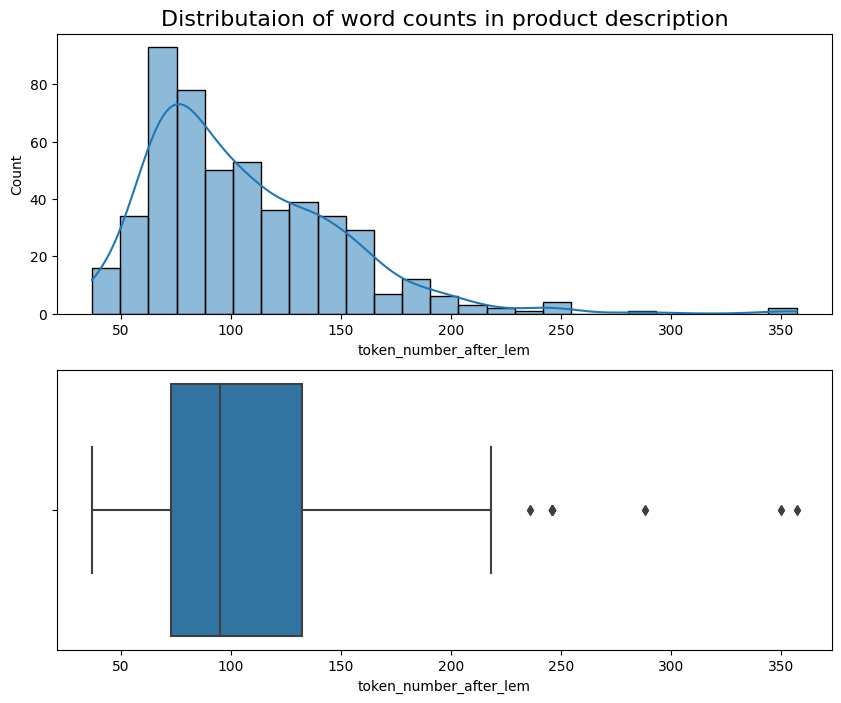

In [25]:
"""
Checking the distribution character of word counts

Statistic test to check character of distribution (ab-/normal):
- D'Agostino and Pearson normality test
- alpha = 0.05
"""

# Data visualisation: histogram and boxplot
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

histplot = sns.histplot(
    data=df_temp,
    x="token_number_after_lem",
    bins=25,
    kde=True,
    ax=axes[0]);
histplot.set_title("Distributaion of word counts in product description", fontsize=16);

boxplot = sns.boxplot(
    data=df_temp,
    x="token_number_after_lem",
    orient="h",
    width=0.9,
    ax=axes[1]);

# Normality test: D'Agostino and Pearson
# Define hypothesis
H0 = "Normal distribution: Data is symmetrically distributed with no skew"
Ha = "NOT normal distribution: The data aren't normally distributed"

# p-value
alpha = 0.05

stat, p = normaltest(df_temp["token_number_after_lem"])
print("Statistics=%.3f, p-value=%.3f" % (stat, p))

# Interpretation
if p > alpha:
    print(f"\n{H0}")
else:
    print(f"\n{Ha}")

Some observations:
* The data aren't normally distributed. There are outliers: 5 examples with more than 220 words in product description

In [26]:
"""
Look in details of example with more than 220 word counts
"""
df_temp[df_temp["token_number_after_lem"] > 220]["full_desc_lem"].iloc[0]

'guidewater jkt pounding teeth swinging tip deluge guidewater keep fishing comfortably long angler headed barn combined best knowledge fabric design technology create full featured highly technical piece angling equipment waterproof breathable layer stretch nylon two inch longer cut make shell choice skiff bay boat jet sled guide design ethic minimalist ergonomically placed pocket custom engineered fish pull vastly improve waterproof reverse coil zipper function put everything need fingertip word retire vest tuck away hood flap wind brushed fleece lined collar provides decadent comfort fishing specific detail glued waterproof zipper drain hole hem pocket attachment patch forceps glass loop modified reversed stretch coat cuff rod holder guidewater longest fishing jacket inch longer deep wading jacket detail light highly breathable durable layer recyclable nylon double ripstop fabric waterproof breathable barrier deluge dwr durable water repellent finish tuck away hood single pull adjust

In our case if we calculate The Interquartile Range (IQR) (``Q3 - Q1``) - the middle 50% (95) of the data consists of product description word counts around 59 (Q3 = 132, Q1 = 73). It has a sense to remove examples with less than 6 word counts and more than 184 (``1.5 * IQR`` =~89) based on this calculation result.

Based on the Descriptive statistics we know that the minimum value of word counts in product description is 37.

Let's look at these examples.

In [27]:
# Check the number of examples with more than 184 word counts
number_of_examples = df_temp.shape[0]
high_word_counts = len(df_temp[df_temp["token_number_after_lem"] > 184]["id"])

print(f"Total number of examples in dataset:\n {number_of_examples}")
print(f"\nNumber of examples with more than 184 word counts: \
{high_word_counts * 100 / number_of_examples}% \n {high_word_counts}")

print("")
display(df_temp[df_temp["token_number_after_lem"] > 184]["full_desc_lem"].iloc[1])

Total number of examples in dataset:
 500

Number of examples with more than 184 word counts: 5.0% 
 25



'crosstown crosstown cross country fully featured commuter backpack ensures life stay organized office bound hiking steep narrow somewhere global commute zippered main compartment feature suspended self adjusting padded laptop sleeve handle laptop secondary compartment open portable office organizer system front catch sleeve hidden zipper provides easy access document stretch woven water bottle pocket fleece lined top pocket protects sunglass electronics spacer mesh backpack strap back padding comfort breathability adjustable sternum strap built safety whistle made denier recycled polyester double weave polyurethane coating dwr durable water repellent finish. detail large zippered main compartment fully padded suspended laptop sleeve separate internal mesh organizer sleeve second zippered compartment office organizer pocket front catch sleeve hidden zipper provides easy access document ticket important material side organizer pocket detachable key chain stretch woven water bottle pocke

* The examples of product descriptions with word count *more than 184* is about 5% - 25 rows.

Usually we can delete these examples, but I want to save all of them for furter investigation because we have only 500 examples in total.

In [28]:
# Get the top 20 most common words among all the product descriptions
p_text = [word.split() for word in df_temp["full_desc_lem"]]

# Flaten the list of lists
p_text = [item for sublist in p_text for item in sublist]

# Top 20
top_20 = pd.DataFrame(
    Counter(p_text).most_common(20),
    columns=["word", "frequency"]
)

top_20

,word,frequency
0,fabric,1000
1,pocket,833
2,made,805
3,polyester,708
4,recyclable,704
5,thread,685
6,recycling,683
7,detail,556
8,weight,541
9,recycled,459


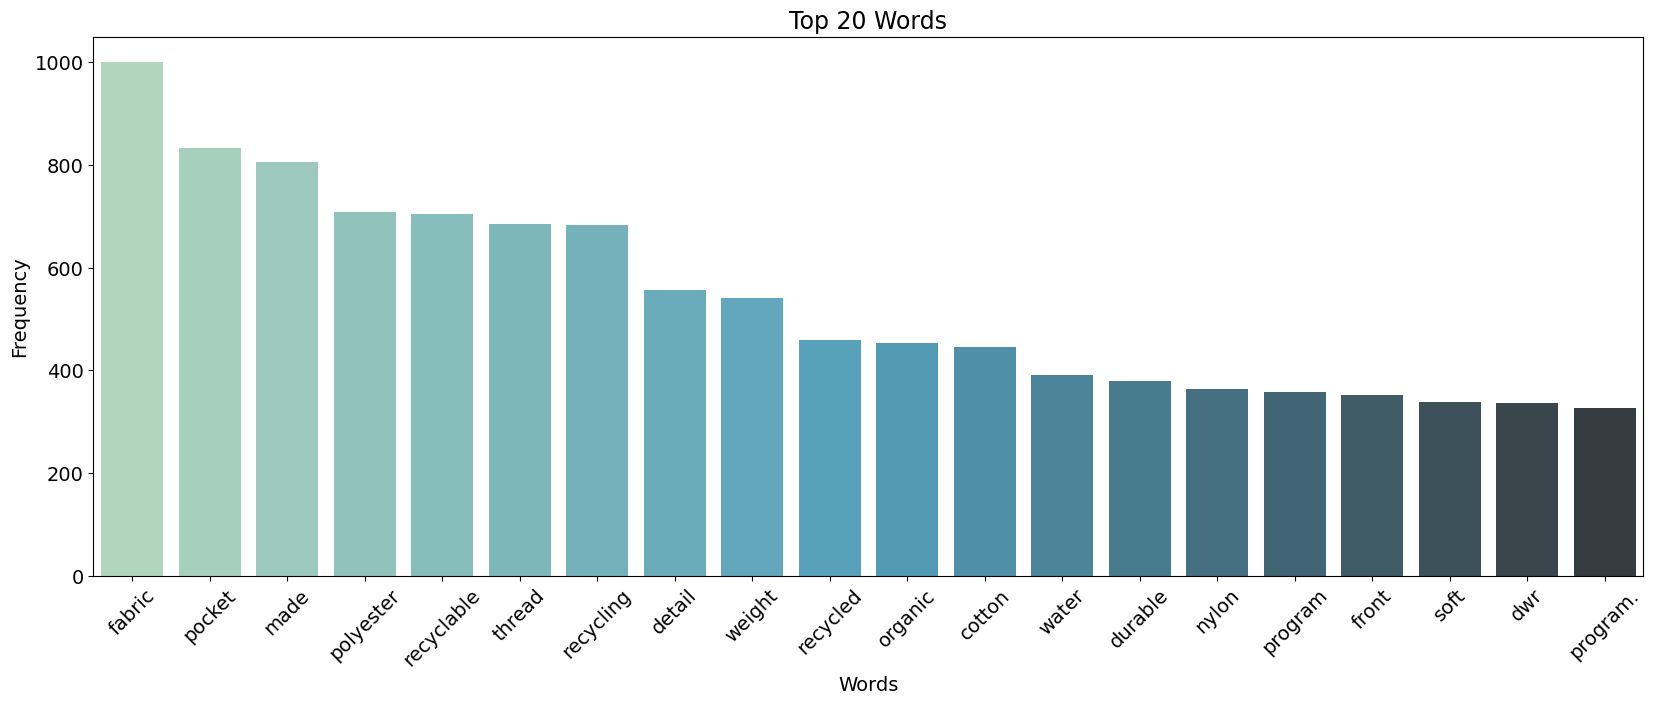

In [29]:
# Plot a bar chart for the top 20 most frequently occuring words
fig = plt.figure(figsize=(20,7))

g = sns.barplot(
    x="word",
    y="frequency",
    data=top_20,
    palette="GnBu_d"
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation=45,
    fontsize=14
)

plt.yticks(fontsize=14)
plt.xlabel("Words", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Top 20 Words", fontsize=17)


plt.show()

Here are the **top 20 words** by frequency among all the descriptions after processing the text:

* ‘fabric’, ‘pocket', 'made', ‘polyester’, 'recyclable' are the top 5

In [30]:
# Get the number of unique words after processing
num_unique_words = len(set(p_text))
num_unique_words

3983

In [31]:
"""
Create dataset with frequency of unique words in product description
- Check the number of words with 1 and 5 frequency level
"""
top_all = pd.DataFrame(
    Counter(p_text).items(),
    columns=["word", "frequency"]
).sort_values(["frequency"], ascending=False)

display(top_all.head(2))

print("\nNumber of words with frequency level equals 1:")
display(top_all[top_all["frequency"] == 1]["word"].count())

print("\nNumber of words with frequency level equals or less than 10:")
display(top_all[top_all["frequency"] <= 10]["word"].count())

,word,frequency
50,fabric,1000
161,pocket,833



Number of words with frequency level equals 1:


1514


Number of words with frequency level equals or less than 10:


3238

In [32]:
# [el for el in df_temp["full_desc_lem"] if " w " in el]

In [33]:
top_all[top_all["frequency"] == 1]["word"][:50]

3224          pushing
3345            think
3223           prefer
3347        integrity
3348             curl
3122          styles.
3127          festive
3123      appropriate
3342          runouts
3213            lucky
3130         downward
3335        efficient
3211           public
3210       refinement
3343           bachar
3209           retain
3208          vitalti
3199           silver
3204              vee
3131           facing
3207        irritable
3341        interview
3340           parent
3339       girlfriend
3206            charm
3334       thoughtful
3344           yerian
3215          roomier
3216           thrift
3124           figure
3136          tasking
3221         frontier
3198    determination
3126         equipped
3201           tarpon
3135        hatchback
3202          florida
3220            quest
3203           borski
3219         puckered
3197      restricting
3134          produce
3218        aimlessly
3217       unofficial
3161         colorado
3239      

*Type of words with frequency equals 1*

Some observations. There are examples with:
* words merged with punctuation (styles., closure.)
* words not related to the topic - product description ("think")

All of these cases could be solved in further study. But in this project at the step of vectorize text data I'll use parameters as min_df and max_df
* max_df is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
* min_df is used for removing terms that appear too infrequently

# 3. Vectorization - TF-IDF Vectorizer

In this project I use TF-IDF Vectorization (Term Frequency - Inverse Document Frequency)
* Term Frequency (TF): This summarizes how often a given word appears within a document
* Inverse Document Frequency (IDF): This downscales the words that appear a lot across documents.

TF-IDF Vectorizer takes into account not only how many times a word appears in a document but also how important that word is to the whole corpus.

Also I use *word level TF-IDF*: matrix representing tf-idf scores of every term in different documents.

In [34]:
"""
Get final_product_base dataset with 3 columns
"""
cols = list(["id"]+["product_name"]+["full_description"]+["full_desc_lem"])

final_product_base = df_temp[cols]
final_product_base.columns = ["id", "product_name", "full_description", "full_desc_lem"]
display(final_product_base.head(2))

final_product_base = final_product_base.dropna(subset=["full_description"])
final_product_base.shape

,id,product_name,full_description,full_desc_lem
0,1,Active classic boxers,Active classic boxers - There's a reason why o...,active classic boxer reason boxer cult favorit...
1,2,Active sport boxer briefs,Active sport boxer briefs - Skinning up Glory ...,active sport boxer brief skinning glory requir...


(500, 4)

***

In [35]:
"""
Generate tfidf matrix model for entire corpus
* ‘min_df’ to 2 which will tell the model to ignore words that appear in less than 5 of the product descriptions.
* ‘max_df’ to .95 which will tell the model to ignore words that appear in more than 95% of the product descriptions.

This will help eliminate words that don’t contribute positively to the model.
Also, reducing the number of words (tokens) will help save time on running the model.

But of course it is better to leave the min, max parameters unchanged in order to get high quality of clustering.
But I have not enough machine's processing capabilities in order to run model faster on the defualt parameters.
"""
tfidf_vect = TfidfVectorizer(min_df=2,
                             max_df=0.95
                            )

tfidf_vect

TfidfVectorizer(max_df=0.95, min_df=2)

In [36]:
# Vectorize clean text -> getting TFIDF matrix
tfidf_embedings = tfidf_vect.fit_transform(final_product_base["full_desc_lem"])
tfidf_embedings.shape

(500, 2291)

## 3.1 Vectorization - TF-IDF Vectorizer: computing cosine similarity

In [37]:
# Computing cosine similarity between vectors in matrix
cos_matrix = cosine_similarity(tfidf_embedings)

# Pairs with metric value more than 0.8
pair_indexes = np.transpose(np.nonzero(cos_matrix > 0.8))
len(pair_indexes)

816

In [38]:
# [el for el in pair_indexes if el[0] == 3]

In [39]:
# Iterating by pair_indexes
id = 4
recommended = []
recommended_products = []

for x in pair_indexes:
    # We want to get high metric value between different product_id (the same equals = 1)
    
    if x[0] == (id-1) and x[0] != x[1]:
        recommended.append(x[1])
        recommended_products.append(final_product_base.iloc[x[1]].product_name)
        
    else: continue
        
    
print(f"Product id: {id}")
print(f"Product name: {final_product_base.iloc[id-1].product_name}")
print(f"Recommended products id: {[el+1 for el in recommended]}")
print(f"Recommended products: {[el for el in recommended_products]}")

Product id: 4
Product name: Alpine guide pants
Recommended products id: [159]
Recommended products: ['Alpine guide pants']


In [40]:
"""
Getting all pairs
"""
i = 0

for x in pair_indexes:
    if x[0] == x[1]: continue
    else:
        print(final_product_base['full_description'][x])
        
    i += 1
    if i > 15: break

3      Alpine guide pants - Skin in, climb ice, switc...
158    Alpine guide pants - Skin in, climb ice, switc...
Name: full_description, dtype: object
4      Alpine wind jkt - On high ridges, steep ice an...
307    Alpine wind jkt - On high ridges, steep ice an...
Name: full_description, dtype: object
7      Print banded betina btm - Our fullest coverage...
219    Solid betina btm - Our fullest coverage bottom...
Name: full_description, dtype: object
19     Cap 1 graphic t-shirt - This tee is made from ...
339    Cap 1 graphic t-shirt - An elegant union of gr...
Name: full_description, dtype: object
19     Cap 1 graphic t-shirt - This tee is made from ...
487    Cap 1 graphic crew - The choice for rest days ...
Name: full_description, dtype: object
21     Cap 2 t-shirt - This one revels in the sweat j...
358    Cap 2 cap sleeve - The fastest-drying of our p...
Name: full_description, dtype: object
21     Cap 2 t-shirt - This one revels in the sweat j...
359    Cap 2 t-shirt - Like a s

In [41]:
# Getting pairs without dublicate values in one pair
correct_pairs = [pair for pair in pair_indexes if pair[0] != pair[1]]

print(len(pair_indexes), "->", len(correct_pairs))

816 -> 316


In [42]:
# Create dict: first value in pair -> keys, second element -> values
correct_pairs_dict = {}

for pair in correct_pairs:
    key = pair[0] + 1 # key - product id, not row index!!!
    correct_pairs_dict.setdefault(key, [])
    correct_pairs_dict[key].append(pair[1]+1)
    
correct_pairs_dict

{4: [159],
 5: [308],
 8: [220],
 20: [340, 488],
 22: [359, 360, 497],
 25: [176],
 27: [28, 452],
 28: [27, 452],
 32: [462, 463],
 35: [282],
 37: [481, 482],
 42: [421],
 46: [409],
 48: [69, 238, 332, 371, 490],
 49: [134],
 52: [444],
 58: [63, 64, 65, 432, 433],
 63: [58, 64, 65, 432, 433],
 64: [58, 63, 65, 432, 433],
 65: [58, 63, 64, 432, 433],
 69: [48, 238, 319, 332, 371, 396, 490],
 72: [334],
 73: [335],
 75: [77],
 76: [125],
 77: [75, 361],
 79: [80],
 80: [79, 339],
 82: [380],
 85: [197],
 87: [88, 202],
 88: [87, 200, 260, 265],
 89: [90, 266, 407],
 90: [89, 202, 266, 269, 406, 407],
 96: [281],
 97: [209],
 107: [351],
 108: [109, 390],
 109: [108, 390],
 110: [391, 392],
 113: [114, 420],
 114: [113, 420],
 118: [119, 350],
 119: [118, 350],
 120: [216],
 125: [76],
 134: [49],
 141: [275],
 143: [232],
 153: [154, 355, 367],
 154: [153, 355, 367],
 159: [4],
 168: [330],
 176: [25],
 179: [473],
 184: [438],
 186: [294],
 188: [305],
 194: [314],
 197: [85],
 200

In [43]:
"""
Added new column: product_ids_tfidf - prediction of similar product ids
Text vectorization - TFIDF
"""
final_product_base["product_ids_tfidf"] = final_product_base.id.map(correct_pairs_dict)

final_product_base.head(20)

,id,product_name,full_description,full_desc_lem,product_ids_tfidf
0,1,Active classic boxers,Active classic boxers - There's a reason why o...,active classic boxer reason boxer cult favorit...,NaN
1,2,Active sport boxer briefs,Active sport boxer briefs - Skinning up Glory ...,active sport boxer brief skinning glory requir...,NaN
2,3,Active sport briefs,Active sport briefs - These superbreathable no...,active sport brief superbreathable fly brief m...,NaN
3,4,Alpine guide pants,"Alpine guide pants - Skin in, climb ice, switc...",alpine guide pant skin climb ice switch rock t...,[159]
4,5,Alpine wind jkt,"Alpine wind jkt - On high ridges, steep ice an...",alpine wind jkt high ridge steep ice anything ...,[308]
5,6,Ascensionist jkt,Ascensionist jkt - Our most technical soft she...,ascensionist jkt technical soft shell full mou...,NaN
6,7,Atom,"Atom - A multitasker's cloud nine, the Atom pl...",atom multitasker cloud atom play part courier ...,NaN
7,8,Print banded betina btm,Print banded betina btm - Our fullest coverage...,print banded betina btm fullest coverage botto...,[220]
8,9,Baby micro d-luxe cardigan,Baby micro d-luxe cardigan - Micro D-Luxe is a...,baby micro luxe cardigan micro luxe heavenly s...,NaN
9,10,Baby sun bucket hat,Baby sun bucket hat - This hat goes on when th...,baby sun bucket hat go sun rise horizon stay r...,NaN


In [44]:
# Let's check our result:
print(f"Key product name: {final_product_base.iloc[19].product_name}")
print(f"Similar products name: {final_product_base.iloc[339].product_name, final_product_base.iloc[487].product_name}")

Key product name: Cap 1 graphic t-shirt
Similar products name: ('Cap 1 graphic t-shirt', 'Cap 1 graphic crew')


In [45]:
# Df for submission file
pairs_by_tfidf = final_product_base.loc[:,["id", "product_ids_tfidf"]]

pairs_by_tfidf.head(10)

,id,product_ids_tfidf
0,1,NaN
1,2,NaN
2,3,NaN
3,4,[159]
4,5,[308]
5,6,NaN
6,7,NaN
7,8,[220]
8,9,NaN
9,10,NaN


In [46]:
# Saving result
pairs_by_tfidf.to_parquet('pairs_by_tfidf.parquet', index=False)
pairs_by_tfidf.head(10)

,id,product_ids_tfidf
0,1,NaN
1,2,NaN
2,3,NaN
3,4,[159]
4,5,[308]
5,6,NaN
6,7,NaN
7,8,[220]
8,9,NaN
9,10,NaN


***

In [47]:
final_product_base[final_product_base.product_name == "Active classic boxers"].index[0]

0

In [48]:
"""
I want to check results without treshold
by product name
"""
def get_index_from(title):
    # function to get index (not id!!!) by product name
    return final_product_base[final_product_base.product_name == title].index[0]

In [49]:
product_name = "Active classic boxers"

product_idx = get_index_from(product_name)

In [50]:
# Generating similar product matrix
similar_product = list(enumerate(cos_matrix[product_idx]))

# Sorting the similar product in descending order
# except of the first row - this is metric value for a string with itself
sorted_similar_product = sorted(similar_product, key = lambda x:x[1], reverse = True)[1:]

In [51]:
sorted_similar_product[:5]

[(18, 0.4780629854233436),
 (493, 0.42752545132136255),
 (364, 0.36343710584842637),
 (1, 0.34486782927171894),
 (494, 0.29734264949823747)]

In [52]:
def get_title_from_index(index):
    title = final_product_base.iloc[index]["product_name"]
    
    return title

In [53]:
"""
Printing the similar product
"""
i=0

print(f"Product_id: {product_idx} --- Product name: {product_name}")

for product in sorted_similar_product:
    print(get_title_from_index(product[0]), f"---- Score value: {round(product[1], 2)}")
    
    i = i+1
    if i>5: break

Product_id: 0 --- Product name: Active classic boxers
Cap 1 boxer briefs ---- Score value: 0.48
Active boxer briefs ---- Score value: 0.43
Organic cotton boxers ---- Score value: 0.36
Active sport boxer briefs ---- Score value: 0.34
Active briefs ---- Score value: 0.3
Cap 3 bottoms ---- Score value: 0.27


Some observations:
* cosine similarity between key product position and other pairs is less than 0.5
* the first 5 product positions are similar to key product name

-> Maybe it has a sense to look at the another methods to get text vectorization

***

# 4. Word embeddings - Word2Vec

* Word embeddings
    - -> representing words as vectors
    - -> high dimensional word features into low dimensional feature vectors by preserving the contextual similarity
    
    
* Combination of  CBOW (Continuous bag of words) and Skip-gram model.
    - CBOW-> tends to predict the probability of a word given a context
    - Skip-gram model-> tries to predict the context for a given word.
    
    
* Pretrained Word2Vec models (huge in size)
    - Google News Word Vectors
    - Freebase names
    - DBPedia vectors (wiki2vec)

*I trained my own Word2Vec model based on our data*

In [54]:
"""
Training own Word2Vec model
"""
## We can use pretrained model: based on the Google news. But I want to try train own model
# word_vectors = api.load("word2vec-google-news-300")

# tokenizing
tokenized_desc = final_product_base["full_desc_lem"].apply(lambda x: x.split())
tokenized_desc

0      [active, classic, boxer, reason, boxer, cult, ...
1      [active, sport, boxer, brief, skinning, glory,...
2      [active, sport, brief, superbreathable, fly, b...
3      [alpine, guide, pant, skin, climb, ice, switch...
4      [alpine, wind, jkt, high, ridge, steep, ice, a...
                             ...                        
495    [cap, bottom, cut, loose, maddening, crowd, se...
496    [cap, crew, crew, take, edge, fickle, weather,...
497    [time, shell, need, use, morning, time, umbrel...
498    [wear, cargo, short, wear, cargo, short, bask,...
499    [wear, short, time, simplify, wear, short, pro...
Name: full_desc_lem, Length: 500, dtype: object

In [55]:
# Initialise model, for more information, please check the Gensim Word2vec documentation
model_w2v = Word2Vec(tokenized_desc,
                     vector_size=300, # to represent in no.of.dimensions-> more the dimension, more the efficiency of model
                     window=5, #takes 10 words surrounding the current word to find context of current word
                     min_count=2, # removes words with frequency less than 2
                     sg = 1, # 1 for skip-gram model
                     hs = 0, # 0 for negative sampling
                     negative = 10, # only takes random 10 negative samples(since dataset is huge, this is done)
                     workers= 1, # no.of threads to train the model - to reproduce same
                     hashfxn = hash, # for reproducability
                     seed = RANDOM_SEED #to generate same random numbers every time
                    )

In [56]:
#Training the built model-> should specify model, size of corpus, epoch
model_w2v.train(tokenized_desc, total_examples= len(final_product_base["full_desc_lem"]), epochs=20)

model_w2v.wv

In [57]:
# Create empty DataFrame for text embeddings
docs_vectors = pd.DataFrame()

# Iterating by text
for doc in final_product_base['full_description']:
    # Create empty DataFrame for words' vectors
    temp = pd.DataFrame()
    
    # Iterating by words in text
    for word in doc.split(' '): 
        try:
            # Getting word's vector by using own pretrained model
            word_vec = model_w2v.wv[word]

            # Adding word's vector to DataFrame
            temp = temp._append(pd.Series(word_vec), ignore_index = True)
            
        except:
            pass
        
    # Computing text's vector as mean value of words' vector (from this part of text)
    doc_vector = temp.mean()
    
    # Adding text's vector to DataFrame for text embeddings
    docs_vectors = docs_vectors._append(doc_vector, ignore_index = True)

# Shape of the DataFrame for text embeddings  
docs_vectors.shape

(500, 300)

In [58]:
# Examples of vectorized text
docs_vectors.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
327,0.058342,0.043020,0.003426,-0.053181,0.001500,-0.162176,0.189242,0.037711,-0.215371,0.133884,...,-0.194869,0.227473,-0.080293,0.074513,0.065860,0.210344,0.091993,0.209954,-0.030586,-0.058941
231,0.035578,0.014222,-0.056718,-0.032941,0.021074,-0.090395,0.180995,0.112298,-0.160691,0.121594,...,-0.236192,0.165265,-0.033417,0.082939,0.092288,0.218655,0.128700,0.164433,0.016875,0.034576
233,0.064038,0.059860,-0.037103,-0.025646,0.062951,-0.093023,0.297959,0.025729,-0.228784,0.151917,...,-0.219542,0.241560,-0.099103,0.028587,0.045156,0.201729,0.142922,0.082220,-0.105947,-0.002546
191,0.042580,0.035272,-0.059585,-0.127487,0.031636,-0.101326,0.303162,0.040269,-0.253207,0.122848,...,-0.240838,0.245666,-0.086404,0.091104,0.043316,0.229028,0.122520,0.169036,-0.024834,0.017173
236,0.176227,-0.104702,-0.142839,0.005136,0.057213,0.000380,0.208147,-0.016395,-0.000520,0.272346,...,-0.052368,0.357147,-0.011595,-0.018273,-0.070547,0.284092,0.175174,-0.013824,-0.009626,0.041982


In [59]:
# Computing cosine similarity between vectors in matrix
cos_matrix_w2v = np.around(cosine_similarity(docs_vectors), 5)
cos_matrix_w2v

array([[1.     , 0.90756, 0.82723, ..., 0.75692, 0.80707, 0.794  ],
       [0.90756, 1.     , 0.90713, ..., 0.8011 , 0.81086, 0.79535],
       [0.82723, 0.90713, 1.     , ..., 0.80337, 0.75215, 0.73747],
       ...,
       [0.75692, 0.8011 , 0.80337, ..., 1.     , 0.70188, 0.72275],
       [0.80707, 0.81086, 0.75215, ..., 0.70188, 1.     , 0.95007],
       [0.794  , 0.79535, 0.73747, ..., 0.72275, 0.95007, 1.     ]],
      dtype=float32)

In [60]:
# Pairs with metric value more than 0.95
pair_indexes_w2v = np.transpose(np.nonzero(cos_matrix_w2v > 0.95))
len(pair_indexes_w2v)

2406

In [61]:
id = 20
recommended = []
recommended_products = []

for x in pair_indexes_w2v:
    # We want to get high metric value between different product_id (the same equals = 1)
    
    if x[0] == (id-1) and x[0] != x[1]:
        recommended.append(x[1])
        recommended_products.append(final_product_base.iloc[x[1]].product_name)
        
    else: continue
        
    
print(f"Product id: {id}")
print(f"Product name: {final_product_base.iloc[id-1].product_name}")
print(f"Recommended products id: {[el+1 for el in recommended]}")
print(f"Recommended products: {[el for el in recommended_products]}")

Product id: 20
Product name: Cap 1 graphic t-shirt
Recommended products id: [21, 60, 172, 340, 341, 487, 488]
Recommended products: ['Cap 1 t-shirt', 'Cap 1 graphic tee', 'Cap 1 t-shirt', 'Cap 1 graphic t-shirt', 'Cap 1 scoop', 'Cap 1 crew', 'Cap 1 graphic crew']


In [62]:
"""
Getting all pairs
"""
i = 0

for x in pair_indexes_w2v:
    if x[0] == x[1]: continue
    else:
        print(final_product_base['full_description'][x])
        
    i += 1
    if i > 15: break

3      Alpine guide pants - Skin in, climb ice, switc...
158    Alpine guide pants - Skin in, climb ice, switc...
Name: full_description, dtype: object
4      Alpine wind jkt - On high ridges, steep ice an...
307    Alpine wind jkt - On high ridges, steep ice an...
Name: full_description, dtype: object
5      Ascensionist jkt - Our most technical soft she...
183    Guide jkt - Sharp granite, sticky verglas, unt...
Name: full_description, dtype: object
5      Ascensionist jkt - Our most technical soft she...
267    Stretch ascent jkt - Simple, stretchy, lightwe...
Name: full_description, dtype: object
5      Ascensionist jkt - Our most technical soft she...
386    Stretch ascent jkt - Simple, stretchy, lightwe...
Name: full_description, dtype: object
5      Ascensionist jkt - Our most technical soft she...
414    Microburst jkt - From the Scottish Highlands t...
Name: full_description, dtype: object
5      Ascensionist jkt - Our most technical soft she...
437    Guide jkt - Sharp granit

In [63]:
# Getting pairs without dublicate values in one pair
correct_pairs_w2v = [pair for pair in pair_indexes_w2v if pair[0] != pair[1]]

print(len(pair_indexes_w2v), "->", len(correct_pairs_w2v))

2406 -> 1906


In [64]:
# Create dict: first value in pair -> keys, second element -> values
correct_pairs_w2v_dict = {}

for pair in correct_pairs_w2v:
    key = pair[0] + 1 # key - product id, not row index!!!
    correct_pairs_w2v_dict.setdefault(key, [])
    correct_pairs_w2v_dict[key].append(pair[1]+1)
    
correct_pairs_w2v_dict

{4: [159],
 5: [308],
 6: [184, 268, 387, 415, 438],
 7: [31, 354, 393, 394, 436, 437, 464],
 8: [220],
 12: [43],
 15: [16, 59, 97, 115, 209, 409, 480, 484, 485],
 16: [15, 480, 484, 485],
 18: [61, 171, 173, 496],
 19: [494],
 20: [21, 60, 172, 340, 341, 487, 488],
 21: [20, 172, 340, 341, 487, 488],
 22: [23, 174, 175, 359, 360, 488, 496, 497],
 23: [22, 173, 174, 175, 359, 360, 496, 497],
 24: [277, 440, 441, 442, 443],
 25: [176, 440, 442, 446],
 26: [36,
  41,
  68,
  71,
  116,
  124,
  138,
  139,
  237,
  239,
  276,
  288,
  322,
  333,
  372,
  373,
  397,
  423,
  448,
  467,
  491,
  493],
 27: [28, 452, 453],
 28: [27, 452, 453],
 29: [454],
 31: [7, 83, 93, 94, 104, 354, 393, 394, 430, 431, 436, 437, 456, 464, 486],
 32: [462, 463, 499, 500],
 33: [51, 129],
 35: [179, 204, 282, 416, 473],
 36: [26,
  41,
  71,
  102,
  116,
  124,
  138,
  139,
  239,
  276,
  288,
  322,
  333,
  334,
  372,
  397,
  423,
  448,
  491,
  493],
 37: [481, 482],
 41: [26,
  36,
  56,
  6

In [65]:
"""
Added new column: product_ids_w2v - prediction of similar product ids
Text vectorization - Word2Vec
"""
final_product_base["product_ids_w2v"] = final_product_base.id.map(correct_pairs_w2v_dict)

final_product_base.head(20)

,id,product_name,full_description,full_desc_lem,product_ids_tfidf,product_ids_w2v
0,1,Active classic boxers,Active classic boxers - There's a reason why o...,active classic boxer reason boxer cult favorit...,NaN,NaN
1,2,Active sport boxer briefs,Active sport boxer briefs - Skinning up Glory ...,active sport boxer brief skinning glory requir...,NaN,NaN
2,3,Active sport briefs,Active sport briefs - These superbreathable no...,active sport brief superbreathable fly brief m...,NaN,NaN
3,4,Alpine guide pants,"Alpine guide pants - Skin in, climb ice, switc...",alpine guide pant skin climb ice switch rock t...,[159],[159]
4,5,Alpine wind jkt,"Alpine wind jkt - On high ridges, steep ice an...",alpine wind jkt high ridge steep ice anything ...,[308],[308]
5,6,Ascensionist jkt,Ascensionist jkt - Our most technical soft she...,ascensionist jkt technical soft shell full mou...,NaN,"[184, 268, 387, 415, 438]"
6,7,Atom,"Atom - A multitasker's cloud nine, the Atom pl...",atom multitasker cloud atom play part courier ...,NaN,"[31, 354, 393, 394, 436, 437, 464]"
7,8,Print banded betina btm,Print banded betina btm - Our fullest coverage...,print banded betina btm fullest coverage botto...,[220],[220]
8,9,Baby micro d-luxe cardigan,Baby micro d-luxe cardigan - Micro D-Luxe is a...,baby micro luxe cardigan micro luxe heavenly s...,NaN,NaN
9,10,Baby sun bucket hat,Baby sun bucket hat - This hat goes on when th...,baby sun bucket hat go sun rise horizon stay r...,NaN,NaN


In [66]:
# Let's check our result:
print(f"Key product name: {final_product_base.iloc[14].product_name}")
print(f"Similar products name: {final_product_base.iloc[15].product_name,final_product_base.iloc[58].product_name, final_product_base.iloc[96].product_name}")

Key product name: Borderless shorts-11 in.
Similar products name: ('Borderless shorts-7 in.', 'Borderless gi shorts', 'Nine trails shorts')


In [67]:
# Df for submission file
pairs_by_w2v = final_product_base.loc[:,["id", "product_ids_w2v"]]
pairs_by_w2v.head(10)

,id,product_ids_w2v
0,1,NaN
1,2,NaN
2,3,NaN
3,4,[159]
4,5,[308]
5,6,"[184, 268, 387, 415, 438]"
6,7,"[31, 354, 393, 394, 436, 437, 464]"
7,8,[220]
8,9,NaN
9,10,NaN


In [68]:
# Saving result
pairs_by_w2v.to_parquet('pairs_by_w2v.parquet', index=False)
pairs_by_w2v.head(10)

,id,product_ids_w2v
0,1,NaN
1,2,NaN
2,3,NaN
3,4,[159]
4,5,[308]
5,6,"[184, 268, 387, 415, 438]"
6,7,"[31, 354, 393, 394, 436, 437, 464]"
7,8,[220]
8,9,NaN
9,10,NaN


***